In [21]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [335]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [285]:
import yfinance as yf
import pandas as pd
from datetime import datetime

In [286]:
import torch

# 1. Terminology
- $p_{t}$: price tick at time point $t$
- $z_{t} = p_{t} - p_{t-1}$: the return obtained at time point $t$
- $f_{t} = \begin{bmatrix}
z_{t - m + 1} & ... & z_{t}
\end{bmatrix}^{T} \in R^{m}$: defines the feature vector of the current market condition at time $t$
- $\delta_{t} \in [-1, 1]$:  the real-time trading decision is made on each time point $t$
- $R_{t}$: the profit made by the trading model
- $U_{T} = \sum_{t=1}^{T}R_{t}$: the accumulated profit throughout the whole period

# 2. Policy:
- A neural network which is used to make trading decision from current feedback, and denoted as:</br></br>
$\quad \quad \quad \large \delta_{t} = \mu_{\theta}(f_{t}, \delta_{t-1}) \in [-1, 1]$ </br></br>
<b>Where:</b> $\left\{\begin{matrix}
\begin{bmatrix}
f_{t} \\
\delta_{t - 1}
\end{bmatrix} \in R^{m+1}: \text{used as an observation to feedback for making the next decision of the agent}\\ 
\mu_{\theta}: \text{the deep neural network (policy), } \theta = \{w^{(l)}, b^{(l)}\}_{l=1}^{L}: \text{a set of parameters of } \mu 
\end{matrix}\right.$
- Architecture:</br>
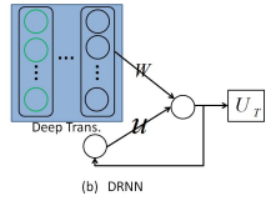

In [287]:
class FuzzyLayer(torch.nn.Module):
    def __init__(self, n_clusters=3, eps=1e-5, device=None):
        super(FuzzyLayer, self).__init__()
        self.n_clusters = n_clusters
        self.eps = eps
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, features):
        # feature_shape = (batch_size, features_dims)
        # means = (1, n_clusters, feature_dims)
        # stds = (1, n_clusters, feature_dims)
        
        # output_shape = (batch_size, n_clusters, feature_dims)
        z = (features - self.means[None]) / (self.stds[None] + self.eps)
        return torch.exp(-z**2)
        
    def fit(self, X, max_iter=300, tol=1e-3):
        X = X.to(self.device)
        centers = X[torch.multinomial(torch.ones(X.size(0), device=self.device), num_samples=self.n_clusters)]
        
        for i in range(max_iter):
            # get labels for each data points with min distances
            labels = torch.argmin(torch.cdist(X, centers, p=2), dim=1)
            
            centers_old = centers.clone()
            # update centers
            for c in range(self.n_clusters):
                centers[c] = X[labels == c].mean(dim=0)
            
            # check if it has convergenced
            if torch.norm(centers_old - centers, p=2, dim=1).mean() <= tol:
                break
        
        labels = torch.argmin(torch.cdist(X, centers, p=2), dim=1)
        self.register_buffer('means', torch.zeros_like(centers))
        self.register_buffer('stds', torch.zeros_like(centers))
        
        for c in range(self.n_clusters):
            X_label = X[labels == c]
            self.means[c] = X_label.mean(dim=0)
            self.stds[c] = X_label.std(dim=0)
            
        return self

In [288]:
class StepLRWithMin(torch.optim.lr_scheduler.StepLR):
    def __init__(self, optimizer, step_size, gamma, min_lr):
        self.min_lr = min_lr
        super().__init__(optimizer, step_size, gamma)

    def get_lr(self):
        lrs = super().get_lr()
        lrs = [max(lr, self.min_lr) for lr in lrs]
        return lrs

# MLP
class MLPNet(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_dims=(256, 512, 256), activation='ReLU', n_outs=1):
        super(MLPNet, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.n_outs = n_outs

        self.module_lists = self._build_mlp_modules()

    def forward(self, *args):
        x = torch.concat(args, dim=1)
        for module in self.module_lists:
            x = module(x)
        return x if self.n_outs == 1 else torch.split(x, self.out_features, dim=1)
        
    def _build_mlp_modules(self):
        modules = torch.nn.ModuleList([])

        in_features = self.in_features
        for hidden_dim in self.hidden_dims:
            modules.append(torch.nn.Linear(in_features=in_features, out_features=hidden_dim))
            modules.append(eval(f'torch.nn.{self.activation}()'))
            in_features = hidden_dim
        modules.append(torch.nn.Linear(in_features=in_features, out_features=self.n_outs * self.out_features))

        return modules

class DRT_MLP_Policy(torch.nn.Module):
    def __init__(self, in_features, hidden_dims=(256, 512, 256), activation='SiLU'):
        super(DRT_MLP_Policy, self).__init__()
        self.feature_encoder = torch.nn.Sequential(
            MLPNet(in_features=in_features, out_features=hidden_dims[-1], hidden_dims=hidden_dims[:-1], activation=activation),
            eval(f'torch.nn.{activation}()')
        )
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dims[-1] + 1, out_features=1),
            torch.nn.Tanh()
        )
    
    def forward(self, features, delta0):
        # feature_shape = (n_dims, feature_dims)
        features = features.view(1, -1)
        f = self.feature_encoder(features)
        x = torch.concat([f, delta0], dim=1)
        return self.output_layer(x)

# LSTM  
class DRT_LSTM_Policy(torch.nn.Module):
    def __init__(self, in_features, hidden_dims=256, num_layers=2):
        super(DRT_LSTM_Policy, self).__init__()
        self.feature_encoder = torch.nn.LSTM(input_size=in_features, hidden_size=hidden_dims, num_layers=num_layers, batch_first=True)
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dims + 1, out_features=1),
            torch.nn.Tanh()
        )
    
    def forward(self, features, delta0):
        # feature_shape = (n_dims, seq_len)
        # after reshape = (1, seg_len, n_dims)
        features = features.permute(1, 0)[None]
        _, (hn, _) = self.feature_encoder(features)
        x = torch.concat([hn[-1], delta0], dim=1)
        return self.output_layer(x)

# transformer
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_seq_len=1024):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        pos = torch.arange(max_seq_len).reshape(-1, 1)
        div_term = torch.exp(- torch.arange(start=0, end=d_model, step=2) * np.log(10000.0) / d_model)
        
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = torch.unsqueeze(input=pe, dim=0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_seq_len:
            raise ValueError("Input sequence length is greater than maximum sequence length for positional encoding.")
        return x + self.pe[:, :seq_len]

class DRT_Trans_Policy(torch.nn.Module):
    def __init__(self, in_features, embed_dims=256, ff_dims=1024, num_layers=2, nhead=2):
        super(DRT_Trans_Policy, self).__init__()
        self.feature_encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=in_features, out_features=embed_dims), # embedding
            torch.nn.SiLU(),
            PositionalEncoding(d_model=embed_dims, max_seq_len=1024), # position encoding
            torch.nn.TransformerEncoder(
                encoder_layer=torch.nn.TransformerEncoderLayer(d_model=embed_dims, nhead=nhead, dim_feedforward=ff_dims, batch_first=True), 
                num_layers=num_layers
            ), # transformer encoder
            torch.nn.ReLU()
        )
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=embed_dims + 1, out_features=1),
            torch.nn.Tanh()
        )
    
    def forward(self, features, delta0):
        # feature_shape = (n_dims, seq_len)
        # after reshape = (1, seg_len, n_dims)
        features = features.permute(1, 0)[None]
        f = self.feature_encoder(features)
        x = torch.concat([f[:, -1, :], delta0], dim=1)
        return self.output_layer(x)

# 3. Reward function:
- It define the profit made by the trading model, and is written as: </br>
$\quad \quad \quad \large R_{t} = R(z_{t}, \delta_{t}, \delta_{t-1}, c) = \delta_{t-1}z_{t} - c |\delta_{t} - \delta_{t-1}|$</br>
<b>where:</b> $\left\{\begin{matrix}
z_{t}: \text{return at time point t}\\ 
\delta_t: \text{decision made by the policy at time point t}\\ 
c: \text{transaction cost}
\end{matrix}\right.$

In [289]:
def reward_func(return_t, delta_t, delta_0, c):
    return delta_0 * return_t - c * torch.abs(delta_t - delta_0)

# 4. Cumulative reward function
- When getting the value function in each time point, the accumulated value throughout the whole training period can be defined a:</br>
$\quad \quad \quad \large U_{T}(R_{1}, ..., R_{T}|\theta) = \sum_{t=1}^{T}R_{t} = \sum_{t=1}^{T}R(z_{t}, \delta_{t}, \delta_{t-1}, c)$</br>
$\rightarrow$ Goal find the best policy to maximize the cumulative reward function

In [259]:
# define loss function
def calc_cumulative_reward(returns, features, policy, c=1, delta0=None):
    delta = torch.zeros(1, 1, dtype=torch.float32, device=returns.device) if delta0 is None else delta0
    R_t = []
    for return_t, features_t in zip(returns, features):
        delta_t = policy(features_t, delta)
        R_t.append(reward_func(return_t, delta_t, delta, c))
        delta = delta_t
    return sum(R_t)

# 5. Direct Reinforcement Learning framework
Optimization problem:</br></br>
$\quad \quad \quad \large \max_{\theta \in \Theta}U_{T}(R_{1}, ..., R_{T}|\theta)$</br></br>
where:$\left\{\begin{matrix}
R_{t} = \delta_{t-1}z_{t} - c |\delta_{t} - \delta_{t-1}|\\ 
\delta_{t} = \mu_{\theta}(f_{t}, \delta_{t-1})
\end{matrix}\right.$ </br>

$\rightarrow$ After optimizing the above equation, we will get a set of parameters $\theta^{*} = \text{argmax}_{\theta \in \Theta}U_{T}(R_{1}, ..., R_{T}|\theta)$ which is the set of parameters of the optimal trading strategy just trained for the currently considered trading environment

# 6. Implement Algorithm
- We set each time series to have length $\text{TIME_STEPS}$, and at each time point $t$ can be the starting time point for any time series.
- At the beginning of $t_{0}$, we initialize $\delta_{0} = 0$, i.e neither buy nor sell.
- To fit the algorithm, instead of solving the problem of maximization, we will transform the problem of minimization by adding a negative sign to the objective function: $\max_{\theta \in \Theta}U_{T}(R_{1}, ..., R_{T}|\theta) = \min_{\theta \in \Theta}-U_{T}(R_{1}, ..., R_{T}|\theta)$

## 6.1 Prepare data and set up configure

In [319]:
# train configure ----------------------------
TIME_STEPS = 100
M = 50 # feature dims
C = 1 # transaction cost
EPOCHS = 2
TEST_RATIO = 0.1
N_CLUSTERS = 3
DEVICE = 'cuda:0'
CKPT_DIR = 'D:\\ML_project'

# optimizer config
LEARNG_RATE = 1e-4
WEIGHT_DECAY = 1e-6
GAMMA = np.exp(-0.0002)
MIN_LR = 1e-6
STEP_SIZE = 5

## 6.2 Read data

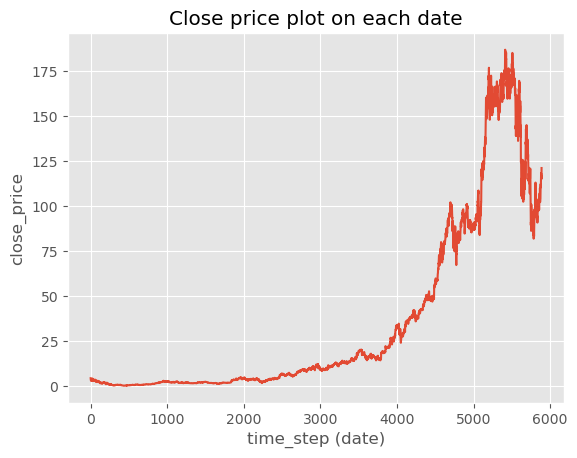

In [320]:
# read data
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

Amazon = yf.download('AMZN', start=start_date, end=end_date, progress=False)
Amazon.to_csv(f'{CKPT_DIR}\\Amazon.csv')

p = np.float32(Amazon['Close'].values)
plt.plot(p)
plt.title('Close price plot on each date')
plt.ylabel('close_price')
plt.xlabel('time_step (date)')
plt.show()

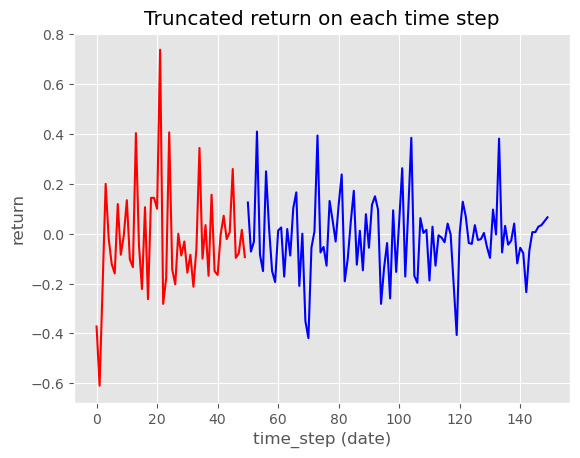

In [321]:
z = p[1:] - p[:-1]
plt.plot(np.arange(M), z[:M], color='r')
plt.plot(np.arange(M, M+TIME_STEPS), z[M:M+TIME_STEPS], color='b')
plt.title('Truncated return on each time step')
plt.ylabel('return')
plt.xlabel('time_step (date)')
plt.show()

## 6.3 Split data

In [322]:
# prepare data, make features f, and returns z
features = torch.from_numpy(np.array([[z[t:t+M]] for t in range(z.size - M)])).to(DEVICE)
returns = torch.from_numpy(z[M:]).to(DEVICE).view(-1, 1, 1)
features.shape, returns.shape

(torch.Size([5837, 1, 50]), torch.Size([5837, 1, 1]))

In [323]:
train_features = features[:features.size(0) - round(features.size(0) * TEST_RATIO)]
test_features = features[features.size(0) - round(features.size(0) * TEST_RATIO):]
train_features.shape, test_features.shape

(torch.Size([5253, 1, 50]), torch.Size([584, 1, 50]))

In [324]:
train_returns = returns[:returns.size(0) - round(returns.size(0) * TEST_RATIO)]
test_returns = returns[returns.size(0) - round(returns.size(0) * TEST_RATIO):]
train_returns.shape, test_returns.shape

(torch.Size([5253, 1, 1]), torch.Size([584, 1, 1]))

## 6.4 Traning policies

In [325]:
POLICY_CONFIGS = {
    'MLP': {
        'in_features': M,
        'hidden_dims': (512, 256, 128, 64),
        'activation': 'SiLU'
    },
    'LSTM': {
        'in_features': 1,
        'hidden_dims': 256,
        'num_layers': 2
    },
    'Trans': {
        'in_features': 1,
        'embed_dims': 64,
        'ff_dims': 1024,
        'num_layers': 1
    }
}

In [326]:
fuzzy_layer = FuzzyLayer(n_clusters=N_CLUSTERS, device=DEVICE)
fuzzy_layer.fit(train_features[:, 0, :])
train_fuzzy_features = fuzzy_layer(train_features)

for policy_name, policy_config in POLICY_CONFIGS.items():  
    for type_ in ['', 'fuzzy_']:
        policy_kwargs = policy_config.copy()
        if type_ == 'fuzzy_':
            policy_kwargs['in_features'] *= N_CLUSTERS
            features_ = train_fuzzy_features
        else:
            features_ = train_features
            
        policy = eval(f'DRT_{policy_name}_Policy')(**policy_kwargs).to(DEVICE)
        optim = torch.optim.Adam(params=policy.parameters(), lr=LEARNG_RATE)
        scheduler = StepLRWithMin(optim, step_size=STEP_SIZE, gamma=GAMMA, min_lr=MIN_LR)

        history = []
        print(f'Training {type_}{policy_name}:')
        for epoch in range(EPOCHS):
            with tqdm(torch.randperm(train_returns.size(0) - TIME_STEPS, device=DEVICE), \
                      bar_format='{l_bar}{bar:5}{r_bar}{bar:-10b}', desc=f'Epoch {epoch}') as pbar:
                for t0 in pbar:
                    # forward and compute loss
                    loss = -calc_cumulative_reward(returns=train_returns[t0: t0+TIME_STEPS], \
                                                   features=features_[t0:t0+TIME_STEPS], \
                                                   policy=policy, c=C)
                    # backward
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    scheduler.step()

                    pbar.set_postfix({'loss': loss.item()})
                    history.append(loss.item())

        torch.save(policy.state_dict(), f=f'{CKPT_DIR}\\{type_}{policy_name}.pt')
        with open(f'{CKPT_DIR}\\{type_}{policy_name}_history.pkl', mode='wb') as file:
            pickle.dump(history, file)

Training MLP:


Epoch 1: 100%|█████| 5153/5153 [17:09<00:00,  5.00it/s, loss=-45.3]                                               


Training fuzzy_MLP:


Epoch 1: 100%|█████| 5153/5153 [17:23<00:00,  4.94it/s, loss=0.644]                                               


Training LSTM:


Epoch 1: 100%|█████| 5153/5153 [56:38<00:00,  1.52it/s, loss=-6.54]                                               


Training fuzzy_LSTM:


Epoch 1: 100%|█████| 5153/5153 [1:21:31<00:00,  1.05it/s, loss=-1.72]                                             


Training Trans:


Epoch 1: 100%|█████| 5153/5153 [34:23<00:00,  2.50it/s, loss=0.84]                                                


Training fuzzy_Trans:


Epoch 0:   0%|     | 17/5153 [00:07<39:12,  2.18it/s, loss=4.38]                                                  


KeyboardInterrupt: 

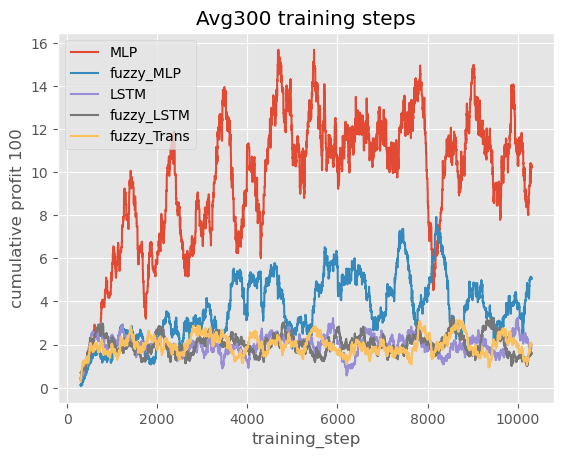

In [357]:
histories = {}
for policy_name in POLICY_CONFIGS.keys():
    if policy_name != 'Trans':
        for type_ in ['', 'fuzzy_']:
            with open(f'{CKPT_DIR}\\{type_}{policy_name}_history.pkl', mode='rb') as file:
                histories[f'{type_}{policy_name}'] = pickle.load(file)
    else:
        with open(f'{CKPT_DIR}\\{policy_name}_history.pkl', mode='rb') as file:
            histories[f'{type_}{policy_name}'] = pickle.load(file)
    
smooth = 300
for policy_name, history in histories.items():
    plt.plot(np.arange(smooth - 1, len(history)), -np.convolve(history, np.ones(shape=(smooth,)) / smooth, mode='valid'), label=policy_name)
plt.title(f'Avg{smooth} training steps')
plt.ylabel(f'cumulative profit {TIME_STEPS}')
plt.xlabel('training_step')
plt.legend()
plt.show()

## 6.5 Running inferences

In [375]:
policies = {}
for policy_name, policy_config in POLICY_CONFIGS.items():
    if policy_name != 'Trans':
        for type_ in ['', 'fuzzy_']:
            policy_kwargs = policy_config.copy()
            if type_ == 'fuzzy_':
                policy_kwargs['in_features'] *= N_CLUSTERS
            policy = eval(f'DRT_{policy_name}_Policy')(**policy_kwargs).to(DEVICE)
            policy.load_state_dict(torch.load(f'{CKPT_DIR}\\{type_}{policy_name}.pt', map_location=DEVICE))
            policies[f'{type_}{policy_name}'] = policy
    else:
        policy_kwargs = policy_config.copy()
        policy = eval(f'DRT_{policy_name}_Policy')(**policy_kwargs).to(DEVICE)
        policy.load_state_dict(torch.load(f'{CKPT_DIR}\\{policy_name}.pt', map_location=DEVICE))
        policies[policy_name] = policy

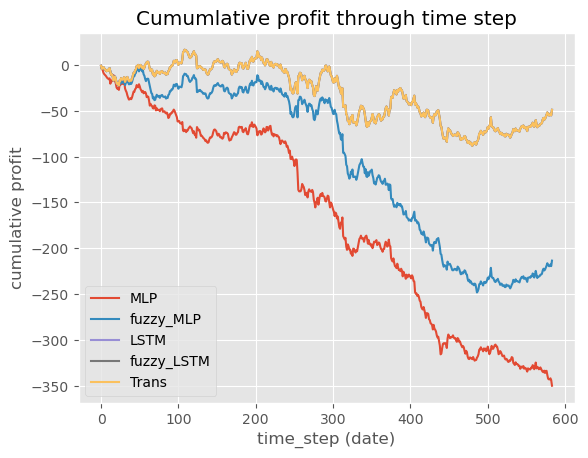

In [383]:
# run inference with test dataset
delta = {
    policy_name: torch.zeros(1, 1, dtype=torch.float32, device=DEVICE)
    for policy_name in policies.keys()
}

list_U_t = {
    policy_name: []
    for policy_name in policies.keys()
}

U_t = {
    policy_name: torch.zeros(1, 1, dtype=torch.float32, device=DEVICE)
    for policy_name in policies.keys()
} 

test_fuzzy_features = fuzzy_layer(test_features)
for t in range(test_returns.size(0)):
    for policy_name in policies.keys():            
        with torch.no_grad():
            delta_t = policies[policy_name](test_fuzzy_features[t] if policy_name.startswith('fuzzy') else test_features[t], delta[policy_name])
        R_t = reward_func(test_returns[t], delta_t, delta[policy_name], C)
        U_t[policy_name] = U_t[policy_name] + R_t
        list_U_t[policy_name].append(U_t[policy_name].item())
        delta[policy_name] = delta_t

for policy_name in policies.keys():
    plt.plot(list_U_t[policy_name], label=policy_name)
plt.title('Cumumlative profit through time step')
plt.ylabel('cumulative profit')
plt.xlabel('time_step (date)')
plt.legend()
plt.show()